In [1]:
# ================== CẤU HÌNH ĐƯỜNG DẪN ==================
DATASET_DIR = 'dataset/news_dataset.csv'
SAVE_MODEL_DIR = 'models/phobert_svm_model'


In [2]:
# ================== TRAIN & LƯU MODEL ==================
from phobert_svm_pipeline import train_phobert_svm

# Train từ CSV (dùng title + content + topic) và lưu toàn bộ artifacts vào SAVE_MODEL_DIR
clf, le, X_test_txt, y_test = train_phobert_svm(
    DATASET_DIR,
    save_dir=SAVE_MODEL_DIR
)


d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


>> Loading PhoBERT from local: models/phobert-base
Run on: cuda
>> Embedding train set...
>> Embedding test set...
>> Training SVM...
>> Evaluation:
                   precision    recall  f1-score   support

        chính trị       0.82      0.86      0.84       757
        công nghệ       0.82      0.84      0.83       757
         giáo dục       0.81      0.84      0.83       757
          kinh tế       0.80      0.78      0.79       758
        pháp luật       0.91      0.91      0.91       757
sức khỏe đời sống       0.78      0.73      0.75       757
         thế giới       0.84      0.86      0.85       758
         thể thao       0.97      0.97      0.97       757
 văn hóa giải trí       0.83      0.77      0.80       757
               xe       0.90      0.93      0.92       757

         accuracy                           0.85      7572
        macro avg       0.85      0.85      0.85      7572
     weighted avg       0.85      0.85      0.85      7572

>> Saved model, encode

In [3]:
# ================== LOAD MODEL & DỰ ĐOÁN ==================
from phobert_svm_pipeline import load_model, predict_topic

# Load lại model từ SAVE_MODEL_DIR
clf, le = load_model(SAVE_MODEL_DIR)

# Dự đoán thử
topic = predict_topic(
    "Mở rộng diện lãnh đạo chủ chốt của Đảng, Nhà nước",
    "Lãnh đạo chủ chốt của Đảng, Nhà nước gồm 5 chức danh Tổng Bí thư, Chủ tịch nước, Thủ tướng, Chủ tịch Quốc hội, Thường trực Ban Bí thư. Bộ Chính trị ngày 8/9 ban hành quy định danh mục vị trí chức danh, nhóm chức danh, chức vụ lãnh đạo của hệ thống chính trị. 5 chức danh lãnh đạo chủ chốt của Đảng, Nhà nước gồm: Tổng Bí thư, Chủ tịch nước, Thủ tướng, Chủ tịch Quốc hội, Thường trực Ban Bí thư. So với quy định năm 2022, chức danh Thường trực Ban Bí thư chuyển từ nhóm lãnh đạo cấp cao lên lãnh đạo chủ chốt.",
    clf, le
)
print("Predicted topic:", topic)

Predicted topic: kinh tế


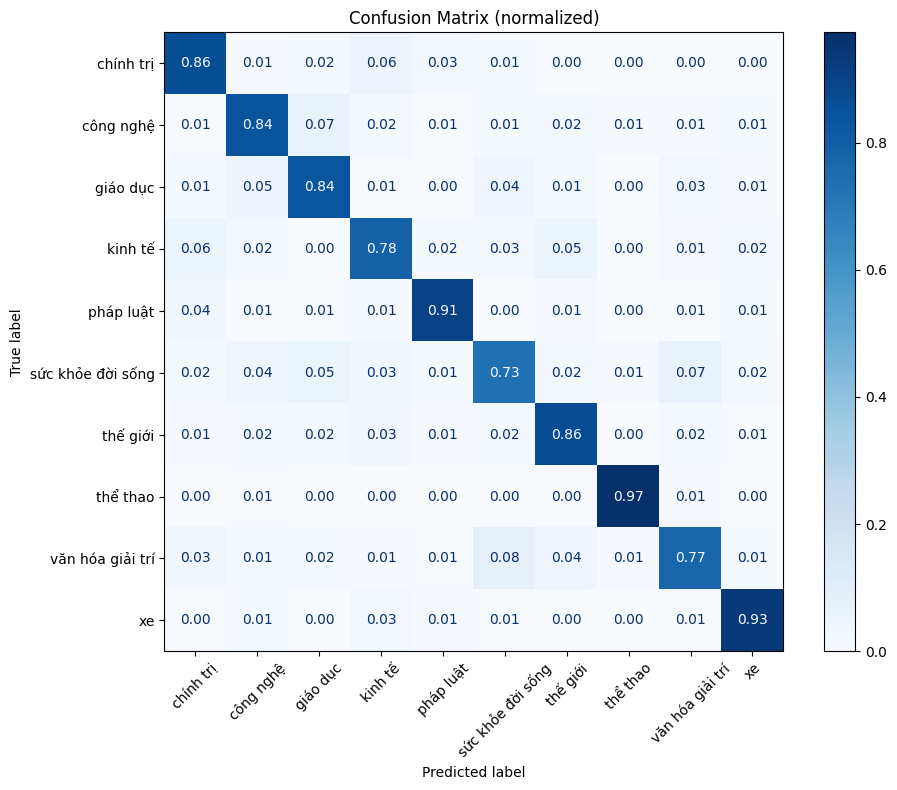

d:\DoAnTotNghiep\Document_Classification_With_Cuckoo_Search\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


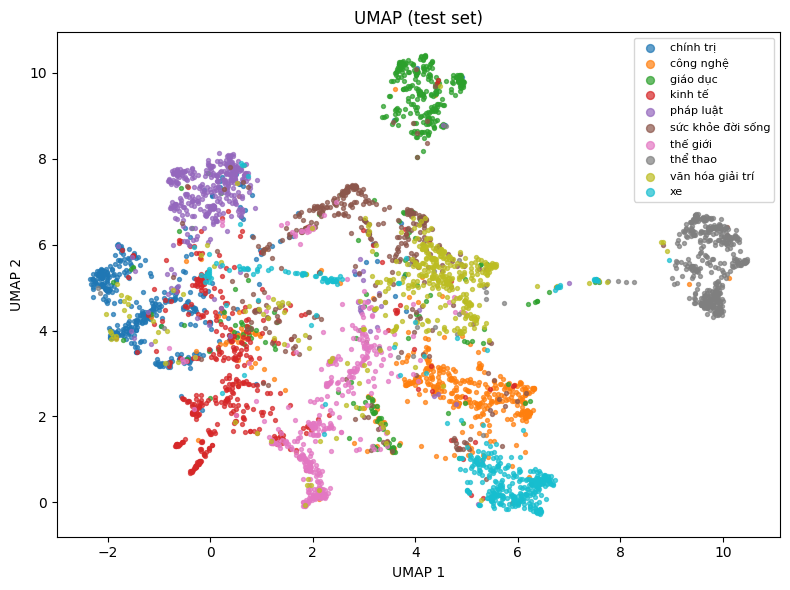

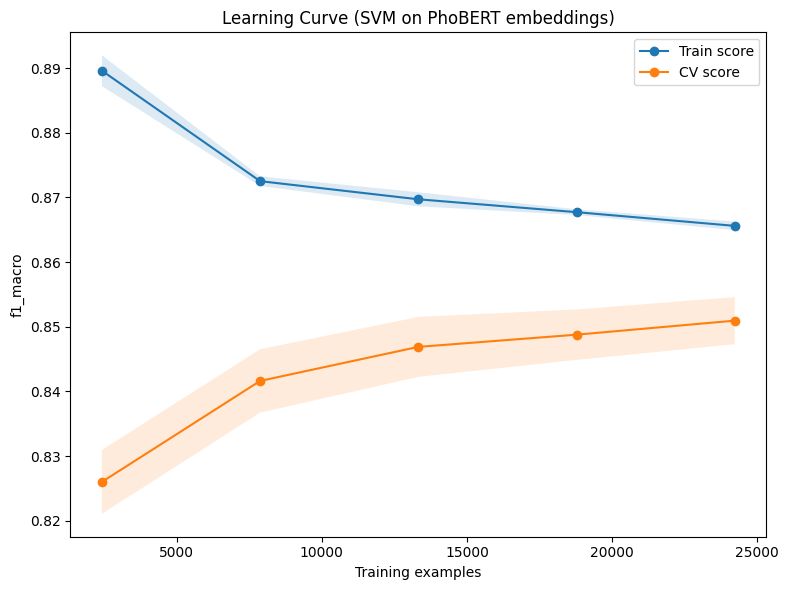

In [4]:
# ================== ĐÁNH GIÁ & TRỰC QUAN HÓA ==================
from phobert_svm_pipeline import (
    load_test_set, load_embeddings,
    evaluate_confusion_matrix, plot_umap_embeddings, plot_learning_curve_svm
)

# Dùng đúng SAVE_MODEL_DIR đã cấu hình
X_test_txt, y_test = load_test_set(SAVE_MODEL_DIR)
X_train, y_train, X_test, y_test_num = load_embeddings(SAVE_MODEL_DIR)

# 1) Confusion matrix (dùng EMBEDDING đã lưu -> không embed lại)
evaluate_confusion_matrix(
    clf, le,
    X_emb=X_test,
    y_true_labels=y_test_num,
    normalize=True
)

# 2) UMAP (dùng EMBEDDING đã lưu)
# Lưu ý: cần cài umap-learn trước khi chạy:  pip install umap-learn
plot_umap_embeddings(
    X_emb=X_test,
    y_int=y_test_num,
    le=le,
    title="UMAP (test set)"
)

# 3) Learning curve (trên EMBEDDING train đã lưu)
plot_learning_curve_svm(
    clf,
    X_emb=X_train,
    y_labels=y_train,
    scoring="f1_macro"
)


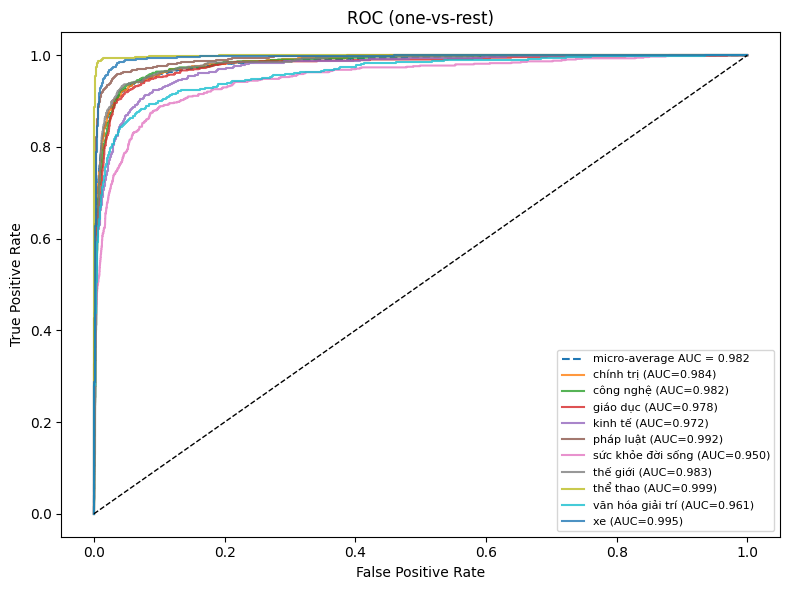

In [5]:
from phobert_svm_pipeline import (_ensure_embeddings, load_model, load_embeddings)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_roc_multiclass(
    clf, le, X_emb=None, X_texts=None, y_true_labels=None,
    batch_size=8, max_length=256,
    figsize=(8,6), title="ROC (one-vs-rest)", max_classes=10
):
    if y_true_labels is None:
        raise ValueError("Cần y_true_labels (int hoặc tên lớp).")
    if isinstance(y_true_labels[0], str):
        y_true = le.transform(y_true_labels)
    else:
        y_true = np.asarray(y_true_labels, dtype=int)

    X = _ensure_embeddings(X_emb=X_emb, X_texts=X_texts,
                           batch_size=batch_size, max_length=max_length)

    scores = clf.decision_function(X)
    if scores.ndim == 1:
        scores = np.vstack([-scores, scores]).T

    y_bin = label_binarize(y_true, classes=np.arange(scores.shape[1]))

    plt.figure(figsize=figsize)
    fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), scores.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linestyle="--", label=f"micro-average AUC = {auc_micro:.3f}")

    classes = np.arange(min(scores.shape[1], max_classes))
    for c in classes:
        fpr, tpr, _ = roc_curve(y_bin[:, c], scores[:, c])
        plt.plot(fpr, tpr, alpha=0.8, label=f"{le.classes_[c]} (AUC={auc(fpr,tpr):.3f})")

    plt.plot([0,1],[0,1],"k--",lw=1)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title); plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout(); plt.show()

clf, le = load_model(SAVE_MODEL_DIR)
X_train, y_train, X_test, y_test_num = load_embeddings(SAVE_MODEL_DIR)

# 3) ROC (dùng EMBEDDING sẵn)
plot_roc_multiclass(clf, le, X_emb=X_test, y_true_labels=y_test_num)